# **Intro**
In this notebook I set up semi-supervised VAE that disentangles the rotation and digits of MNIST numbers. 
This is almost identical to "[DIVA: DOMAIN INVARIANT VARIATIONAL AUTOENCODERS](https://arxiv.org/pdf/1905.10427.pdf)".
To breifly describe the model, we have 3 independent encoders that encode for different sources of variation: cell-type proportions, sample_id, and everything else (slack).
In this experiment, there is a cell-type specific drug-perturbation for some of the samples.
In particular, cell-type 6 has a different expression profile for samples 0, 5, 6, 7.
Additionally, these samples do not have ground-truth cell-type proportions.
This is analogous to the problem of trying to find cell-type specific perturbation effects from bulk RNA-Seq data.
We see that cell-type 6 looks different in the slack when comparing perturbed to non-perturbed samples.

This is acheived through disentangling a majority of the cell-type and sample-type variation. 
To enforce this disentanglement, there are two different encoders with different losses.
Sample-classification loss is on one set of latent codes.
Proportion-estimation loss is on another set of latent codes.
No loss is applied to the slack latent codes.
The embeddings are then concatenated together and used as input to a joint decoder.

Proportion estimation is done in a semi-supervised way (borrowing heavily from saemundsson and bjlkeng).
When the proportions are available, we directly input them into the decoder and simultaneously train the auxilliary proportion-estimator.
When they are unavailable, we use the output of the auxilliary proportion-estimator as the input to the proportion-decoder.
When used in the semi-supervised mode, the classification loss is calculated by comparing the classifier output to the latent digit representation.


The experimental set-up is as follows:
The sample 0, 5, 6, 7 are perturbed. 
This means that cell-typ 6 has a different gene-expression profile for those samples.
Samples 1 and 2 have ground truth cell-type proportions (single-cell generated pseudobulks).
Samples 0, 3-9 do not have ground truth cell-type proportions, which is a stand in for real bulk data.
However, since this is a simulation it is actually generated from single-cell pseudobulks, we just dont look at the proportions.

We show that our latent representations of cell-type and sample are disentangled.
We show that we are able to manipulate the latent space in order to simulate specific cells or samples.
We show that the slack is able to find cell-type specific effects -- **even when the effect is only observed in bulk**

This code was based off of DIVA's codebase: https://github.com/AMLab-Amsterdam/DIVA

Semi-supervised training method was take from here:
And this tutorial: https://github.com/bjlkeng/sandbox/tree/master/notebooks/vae-semi_supervised_learning with an awesome accomanying blogpost: https://bjlkeng.github.io/posts/semi-supervised-learning-with-variational-autoencoders/

Another codebase referenced: https://github.com/saemundsson/semisupervised_vae


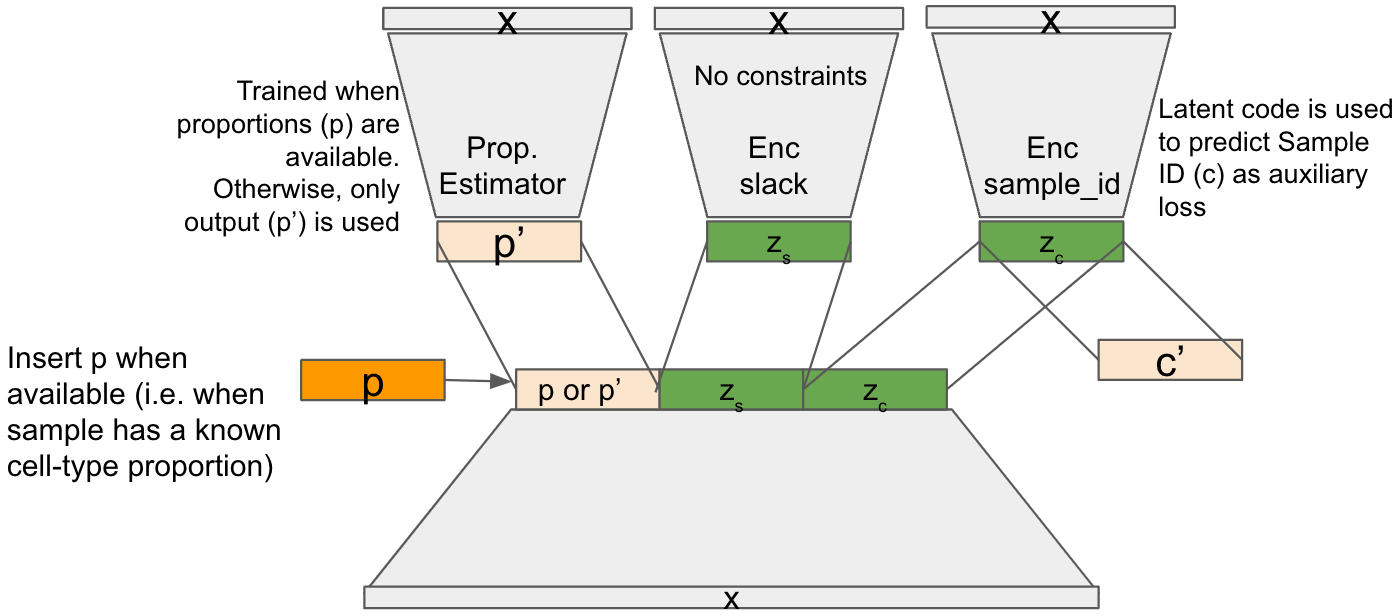

# **Imports**

In [6]:
# import the our code
import sys
sys.path.insert(1, '../../')
from sc_preprocessing import sc_preprocess
from diva import diva_m2

# general imports
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from scipy.stats import spearmanr, pearsonr
from collections import Counter
from sklearn.preprocessing import MinMaxScaler, RobustScaler

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale


# programming stuff
import time
import os, sys
import pickle
from pathlib import Path





# **Set up experiment parameters** 


In [7]:

# number of pseudobulks PER patient
n_train = 1000

# batch size used during training
batch_size = 500

# number of patients/domains/samples expected
n_tot_samples = 10


### create the domains label 
Label_full = np.concatenate([np.full(n_train, 0), np.full(n_train, 1),
                            np.full(n_train, 2), np.full(n_train, 3),
                            np.full(n_train, 4), np.full(n_train, 5),
                            np.full(n_train, 6), np.full(n_train, 7),
                            np.full(n_train, 8), np.full(n_train, 9)], axis=0)
label_full = to_categorical(Label_full)

### create the drugs label 
Drug_full = np.concatenate([np.full(n_train, 1), np.full(n_train, 0),
                            np.full(n_train, 0), np.full(n_train, 0),
                            np.full(n_train, 0), np.full(n_train, 1),
                            np.full(n_train, 1), np.full(n_train, 1),
                            np.full(n_train, 0), np.full(n_train, 0)], axis=0)
drug_full = to_categorical(Drug_full)

# indexes for the training
# 1-2 is labeled 
# 0,3-9 is unlabeled
idx_train = np.where(np.logical_and(Label_full > 0, Label_full < 3))[0] #np.where(np.logical_and(Label_full > -1, Label_full < 2))[0]
idx_unlab = np.where(np.logical_or(Label_full == 0, Label_full > 2))[0] #np.where(Label_full >= 2)[0]
idx_drug = np.where(Drug_full > 0)[0]
idx_5 = np.where(Label_full == 5)[0]
idx_0 = np.where(Label_full==0)[0]

# set up paths
res_path = f"{os.getcwd()}/../../results/single_cell_data/buddiM2_pbmc/"
data_path = f"{os.getcwd()}/../../data/single_cell_data/augmented_pbmc_data/"

# cibersort results
cibersort_file_path = f"{os.getcwd()}/../../results/single_cell_data/cibersort_pbmc/pbmc6k-mono_9_1_cybersort_mix_CIBERSORTx_Job11_Results.csv"



# **Load Data**

In [8]:

def read_gene_file(res_path, exp_id):
    gene_file = os.path.join(res_path, f"train-{exp_id}-DIVA_features.pkl")
    gene_path = Path(gene_file)
    gene_df_train = pickle.load( open( gene_path, "rb" ) )
    return gene_df_train

# read in the expression data and labels
exp_id = "pbmc6k-mono"
X_full, Y_full, gene_df = sc_preprocess.read_all_diva_files(data_path, range(10), exp_id)
X_full.columns = gene_df

# get the features used for training
train_features = read_gene_file(res_path, exp_id)
train_features = train_features.iloc[:,0]

# process the training matrix
X_full = X_full.reindex(columns=train_features, fill_value=0)
X_full = X_full.to_numpy()

## normalize within sample
clip_upper = np.quantile(X_full, 0.9)
X_full = np.clip(X_full, 0, clip_upper)
scaler = MinMaxScaler()
scaler.fit(X_full)
X_full = scaler.transform(X_full)

# for unknown proportions; i.e. 3 
X_unkp = X_full[idx_unlab,]
label_unkp = label_full[idx_unlab,]
drug_unkp = drug_full[idx_unlab,]
y_unkp = Y_full.iloc[idx_unlab]

# for known proportions
X_kp = X_full[idx_train,]
label_kp = label_full[idx_train,]
drug_kp = drug_full[idx_train,]
y_kp = Y_full.iloc[idx_train]


pbmc6k_enc_unlab = tf.keras.models.load_model(f"{res_path}/{exp_id}_encoder_unlab")
pbmc6k_enc_lab = tf.keras.models.load_model(f"{res_path}/{exp_id}_encoder_lab")
pbmc6k_dec = tf.keras.models.load_model(f"{res_path}/{exp_id}_decoder")
pbmc6k_classifier = tf.keras.models.load_model(f"{res_path}/{exp_id}_classifier")



2023-01-24 10:01:19.169888: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# **Make TSNE of raw and training data**

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.050s...
[t-SNE] Computed neighbors for 10000 samples in 6.288s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 2.424404
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.446976
[t-SNE] KL divergence after 300 iterations: 2.276628
(10000, 2)
(10000, 2)


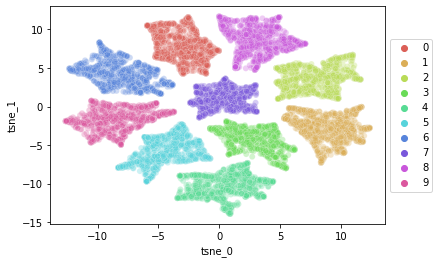

In [9]:
## plot samples
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X_full)

plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
plot_df['augmentation'] = Label_full

g = sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="augmentation",
    palette=sns.color_palette("hls", n_tot_samples),
    legend="full",
    alpha=0.3
)
g.legend(loc='center left', bbox_to_anchor=(1, 0.5))


# **Plot Loss Curves**

In [10]:
def read_loss_file(res_path, exp_id):
    loss_file = os.path.join(res_path, f"train-{exp_id}-DIVA_loss.pkl")
    loss_path = Path(loss_file)
    loss_df = pickle.load( open( loss_path, "rb" ) )
    return loss_df

def make_loss_fig(loss_df, ax, title, loss_to_plot):
    ## plot loss
    g = sns.lineplot(
        x="batch", y=loss_to_plot,
        data=loss_df,
        hue="type",
        legend="full",
        alpha=0.3, ax= ax
    )
    ax.set_title(title)
    return g





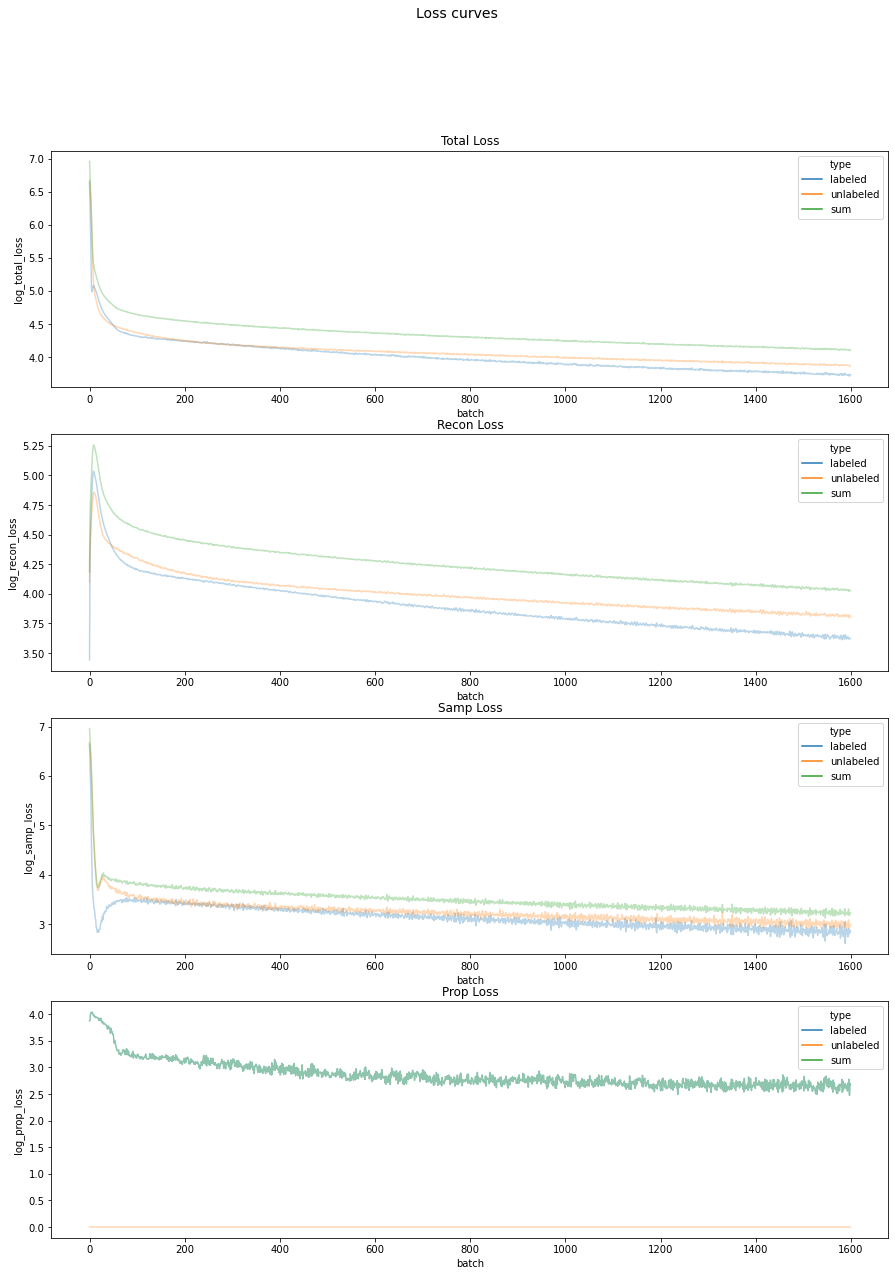

In [11]:
loss_df = read_loss_file(res_path, exp_id)


fig, axs = plt.subplots(4, figsize=(15,20))

make_loss_fig(loss_df, ax=axs[0], title=f"Total Loss", loss_to_plot="log_total_loss")
make_loss_fig(loss_df, ax=axs[1], title=f"Recon Loss", loss_to_plot="log_recon_loss")
make_loss_fig(loss_df, ax=axs[2], title=f"Samp Loss", loss_to_plot="log_samp_loss")
make_loss_fig(loss_df, ax=axs[3], title=f"Prop Loss", loss_to_plot="log_prop_loss")


fig.suptitle("Loss curves", fontsize=14)

fig.show()

# **Compare performance**

In [12]:
def plot_cell_specific_corr(xval, yval, ax, title, xlab, ylab, class_id):

    plot_df = pd.DataFrame(list(zip(xval, yval)))
    plot_df.columns = [xlab, ylab]

    g = sns.scatterplot(
        x=xlab, y=ylab,
        data=plot_df,ax=ax,
        hue=class_id
    )
    g.set(ylim=(0, 1))
    g.set(xlim=(0, 1))
    g.plot([0, 1], [0, 1], transform=g.transAxes)

    ax.set_title(title)
    return g

### unlabeled data

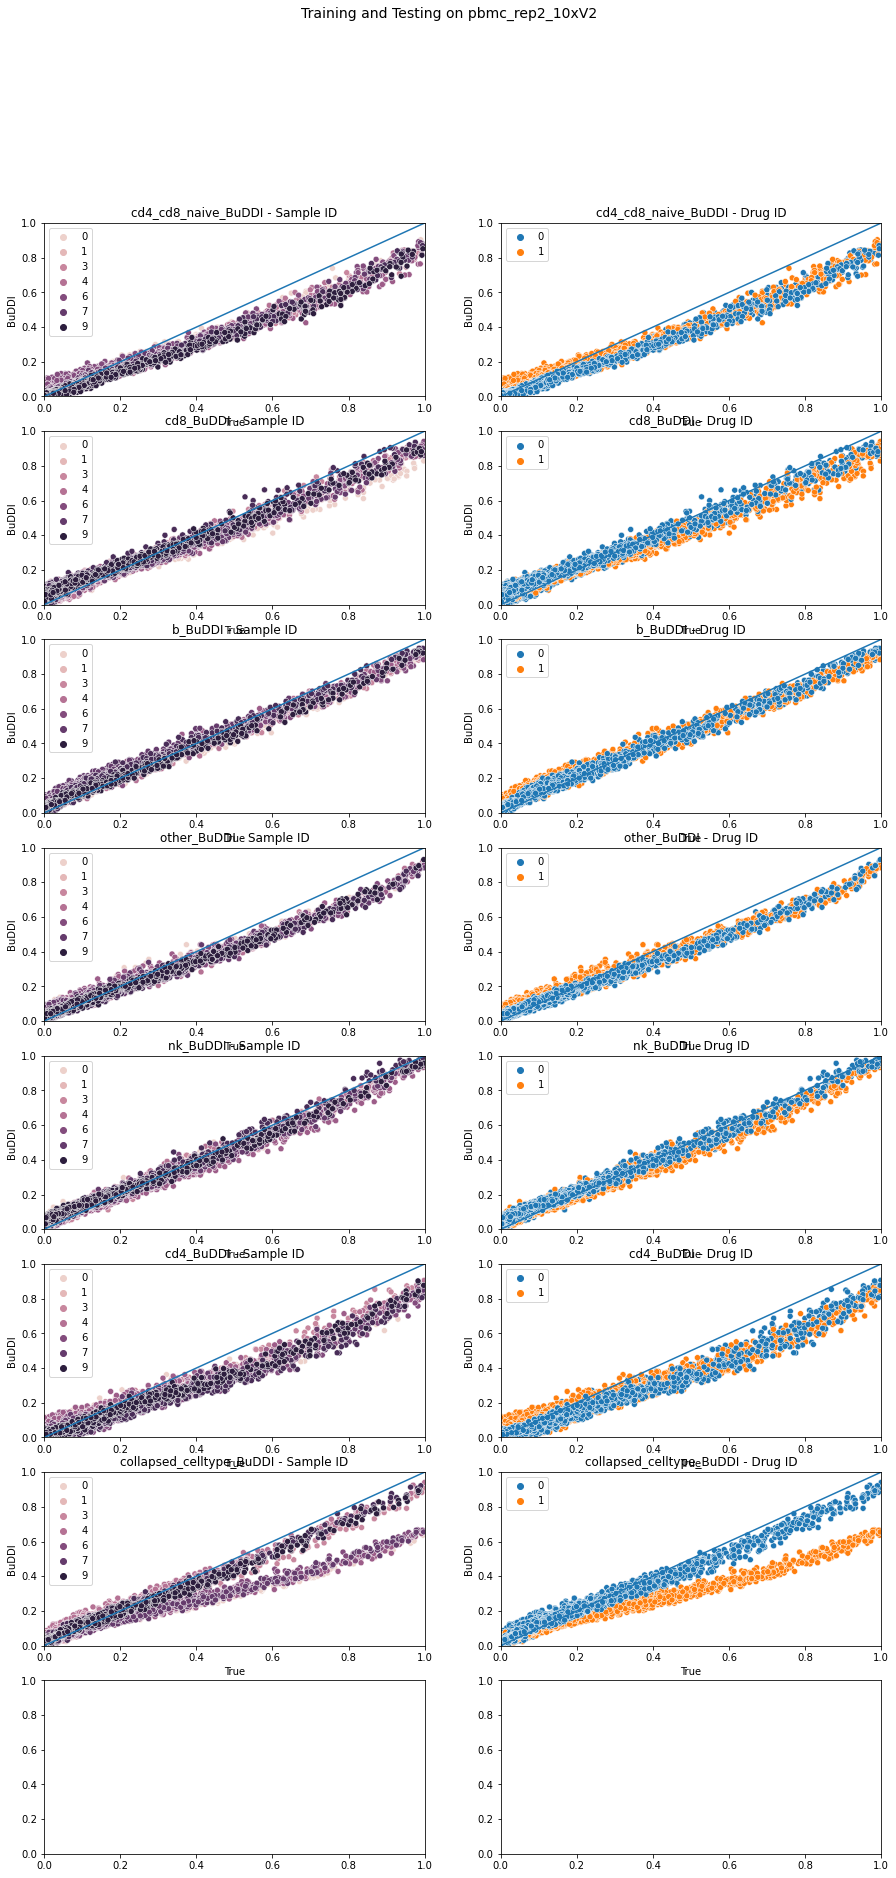

In [35]:
# plot the  performance of buddi on the unlabeled data

idx_tmp = idx_unlab
X_tmp = X_full[idx_tmp,]

# make predictions
prop_outputs = pbmc6k_classifier.predict(X_tmp, batch_size=batch_size)

## plot for the unlabeled

prop_df = pd.DataFrame(prop_outputs, columns=Y_full.columns)
true_prop_df = Y_full.iloc[idx_tmp]

fig, axs = plt.subplots(8, 2, figsize=(15,30))
row_idx = 0
for curr_cell in true_prop_df.columns:

    plot_cell_specific_corr(true_prop_df[curr_cell], prop_df[curr_cell], axs[row_idx,0], title=f"{curr_cell}_BuDDI - Sample ID", xlab="True", ylab="BuDDI", class_id=Label_full[idx_tmp])
    plot_cell_specific_corr(true_prop_df[curr_cell], prop_df[curr_cell], axs[row_idx,1], title=f"{curr_cell}_BuDDI - Drug ID", xlab="True", ylab="BuDDI", class_id=Drug_full[idx_tmp])
    row_idx = row_idx +1


fig.suptitle("Training and Testing on pbmc_rep2_10xV2", fontsize=14)

fig.show()

### compare with CIBERSORTx

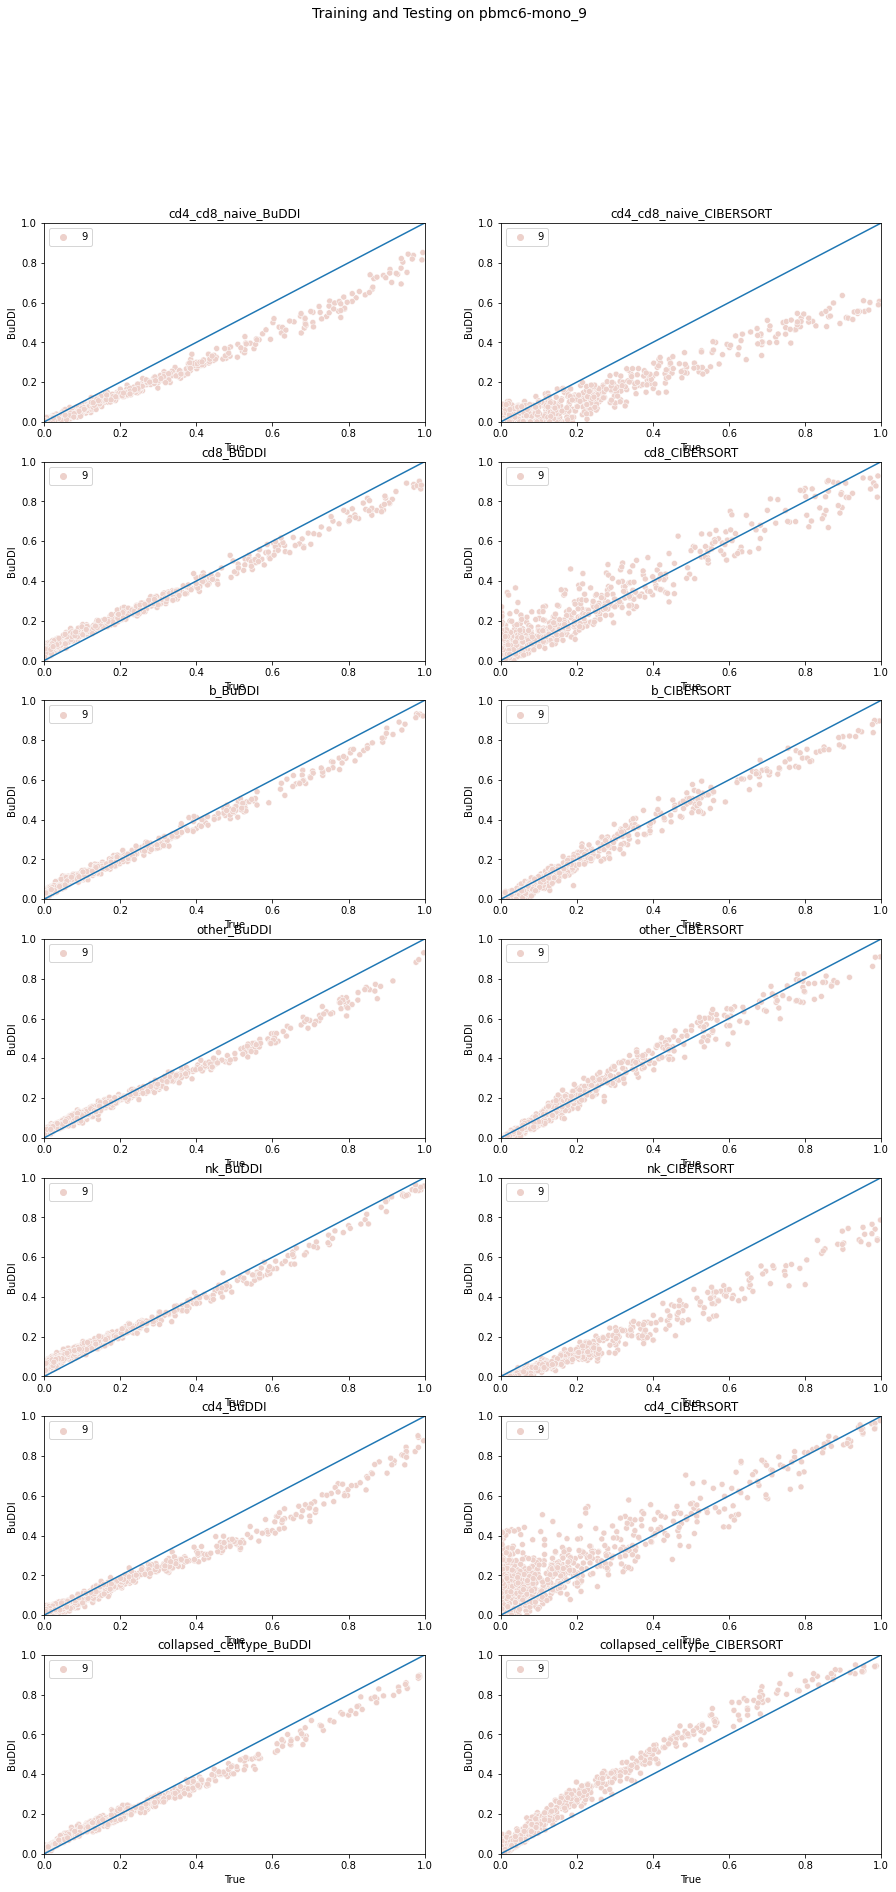

In [14]:
idx_9 = np.where(Label_full == 9)[0]
true_9_prop_df = Y_full.iloc[idx_9]
X_unkp_9 = X_full[idx_9,]

# read in cibersort
cibersort_df = pd.read_csv(cibersort_file_path)
cibersort_df = cibersort_df.reindex(columns=Y_full.columns, fill_value=0)

# make predictions
prop_outputs = pbmc6k_classifier.predict(X_unkp_9, batch_size=batch_size)

## plot for the unlabeled
prop_df = pd.DataFrame(prop_outputs, columns=Y_full.columns)
true_prop_df = Y_full.iloc[idx_9]



fig, axs = plt.subplots(7, 2, figsize=(15,30))
row_idx = 0
for curr_cell in true_prop_df.columns:

    plot_cell_specific_corr(true_prop_df[curr_cell], prop_df[curr_cell], axs[row_idx,0], title=f"{curr_cell}_BuDDI", xlab="True", ylab="BuDDI", class_id=Label_full[idx_9])
    plot_cell_specific_corr(true_prop_df[curr_cell], cibersort_df[curr_cell], axs[row_idx,1], title=f"{curr_cell}_CIBERSORT", xlab="True", ylab="BuDDI", class_id=Label_full[idx_9])
    row_idx = row_idx +1


fig.suptitle("Training and Testing on pbmc6-mono_9", fontsize=14)

fig.show()

### compare on labeled data

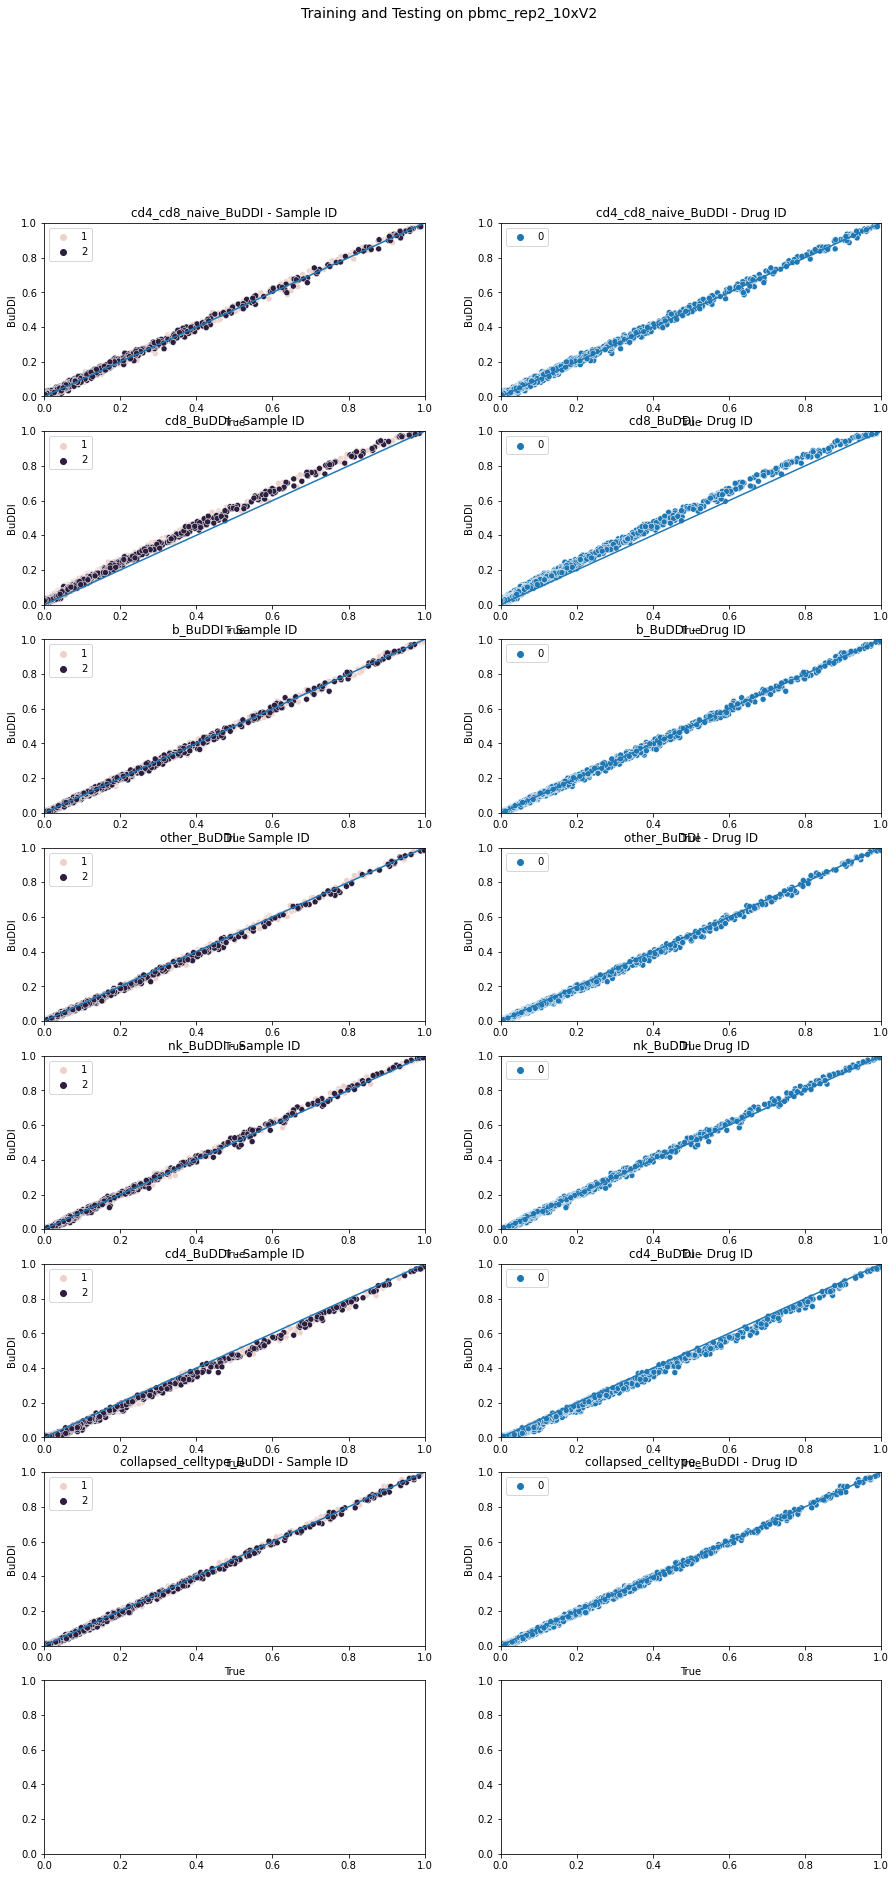

In [15]:
# make predictions
prop_outputs = pbmc6k_classifier.predict(X_kp, batch_size=batch_size)


## plot for the labeled

prop_df = pd.DataFrame(prop_outputs, columns=Y_full.columns)
true_prop_df = Y_full.iloc[idx_train]

fig, axs = plt.subplots(8, 2, figsize=(15,30))
row_idx = 0
for curr_cell in true_prop_df.columns:

    plot_cell_specific_corr(true_prop_df[curr_cell], prop_df[curr_cell], axs[row_idx,0], title=f"{curr_cell}_BuDDI - Sample ID", xlab="True", ylab="BuDDI", class_id=Label_full[idx_train])
    plot_cell_specific_corr(true_prop_df[curr_cell], prop_df[curr_cell], axs[row_idx,1], title=f"{curr_cell}_BuDDI - Drug ID", xlab="True", ylab="BuDDI", class_id=Drug_full[idx_train])
    row_idx = row_idx +1


fig.suptitle("Training and Testing on pbmc_rep2_10xV2", fontsize=14)

fig.show()

### compare errors

In [16]:
def read_diva_result_file(res_path, train_id, test_id, unlab_id):
    res_file = os.path.join(res_path, f"train-{train_id}-test-{test_id}-DIVA.pkl")
    res_path = Path(res_file)
    res_df = pickle.load( open( res_path, "rb" ) )
    return res_df

def read_bp_result_file(res_path, train_id, test_id, num_samp=1000):
    res_file = os.path.join(res_path, f"train-{train_id}-test-{test_id}-bp_{num_samp}_init.tsv")
    res_df = pd.read_csv(res_file, sep="\t")
    return res_df

def read_bp_init_file(res_path, train_id, test_id, num_samp=1000):
    res_file = os.path.join(res_path, f"train-{train_id}-test-{test_id}-bp_{num_samp}_init.tsv")
    res_df = pd.read_csv(res_file, sep="\t")
    return res_df




In [17]:
# helper methods for evaluation
def sum_abs_error(y_pred, y_true):
  return sum(abs(y_pred - y_true))

def mean_abs_error(y_pred, y_true):
  return np.mean(abs(y_pred - y_true))

def mean_sqr_error(y_pred, y_true):
  return np.mean((y_pred - y_true)**2)

def get_errors(y_true, y_est):
  mse_err = [mean_sqr_error(y_true[idx], y_est[idx]) 
                  for idx in range(0, y_est.shape[0])]

  print(f"MSqE mean: {np.mean(mse_err)}, median: {np.median(mse_err)}, max: {max(mse_err)}")

  spr_err = [spearmanr(y_true[idx].astype(float), y_est[idx].astype(float))[0]
                    for idx in range(0, y_est.shape[0])]
  print(f"Spearman mean: {np.mean(spr_err)}, median: {np.median(spr_err)}, max: {max(spr_err)}")

  pear_err = [pearsonr(y_true[idx].astype(float), y_est[idx].astype(float))[0]
                    for idx in range(0, y_est.shape[0])]
  print(f"Pearson mean: {np.mean(pear_err)}, median: {np.median(pear_err)}, max: {max(pear_err)}")

  error_list = [mse_err, spr_err, pear_err]
  plot_df = [item for sublist in error_list for item in sublist]
  plot_df = pd.DataFrame(plot_df)
  plot_df.columns = ["error"]
  plot_df["error_type"] = ["MSQ"]*y_est.shape[0] + ["SPR"]*y_est.shape[0] + ["PEAR"]*y_est.shape[0]

  return plot_df


def get_errors_single(y_true, y_est):
  mse_err = [mean_sqr_error(y_true, y_est)]

  print(f"MSqE mean: {np.mean(mse_err)}, median: {np.median(mse_err)}, max: {max(mse_err)}")

  spr_err = [spearmanr(y_true, y_est)[0]]
  print(f"Spearman mean: {np.mean(spr_err)}, median: {np.median(spr_err)}, max: {max(spr_err)}")

  pear_err = [pearsonr(y_true, y_est)[0]]
  print(f"Pearson mean: {np.mean(pear_err)}, median: {np.median(pear_err)}, max: {max(pear_err)}")

  error_list = [mse_err, spr_err, pear_err]
  plot_df = [item for sublist in error_list for item in sublist]
  plot_df = pd.DataFrame(plot_df)
  plot_df.columns = ["error"]
  plot_df["error_type"] = ["MSQ"] + ["SPR"] + ["PEAR"]

  return plot_df




MSqE mean: 0.0022631995863993566, median: 0.0018159627609161386, max: 0.010936747979675634
Spearman mean: 0.8274913647270963, median: 0.8928571428571429, max: 1.0
Pearson mean: 0.9779230801225088, median: 0.9882530994939036, max: 0.9999420861024952
MSqE mean: 0.006378399853592137, median: 0.003751361406620586, max: 0.04873875241396046
Spearman mean: 0.7233221563945795, median: 0.7857142857142859, max: 1.0
Pearson mean: 0.9003242968051155, median: 0.9494092555182116, max: 0.999941455255848


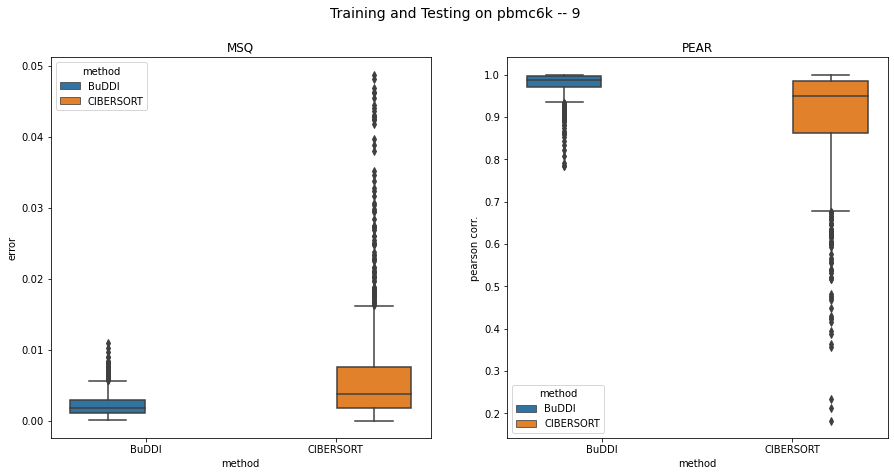

In [18]:
# We only ran the cibersort on index 9
idx_tmp = np.where(Label_full == 9)[0]
X_tmp = X_full[idx_tmp,]
Y_tmp = Y_full.iloc[idx_tmp]

# make predictions
prop_outputs = pbmc6k_classifier.predict(X_tmp, batch_size=batch_size)

# read in cibersort
cibersort_df = pd.read_csv(cibersort_file_path)
cibersort_df = cibersort_df.reindex(columns=Y_full.columns, fill_value=0)

# calculate the error
buddi_err = get_errors(Y_tmp.to_numpy(), prop_outputs)
cibersort_err = get_errors(Y_tmp.to_numpy(), cibersort_df.to_numpy())

# format the errors
buddi_err["experiment"] = ["true_val"]*buddi_err.shape[0]
buddi_err["method"] = ["BuDDI"]*buddi_err.shape[0]

cibersort_err["experiment"] = ["true_val"]*cibersort_err.shape[0]
cibersort_err["method"] = ["CIBERSORT"]*cibersort_err.shape[0]

plot_df = pd.concat([buddi_err, cibersort_err])

# plot
fig, axs = plt.subplots(1, 2, figsize=(15,7))
sns.boxplot(data=plot_df[plot_df["error_type"] == "MSQ"], 
            x="method", y="error",
            hue="method", ax= axs[0])
axs[0].set_title("MSQ")

sns.boxplot(data=plot_df[plot_df["error_type"] == "PEAR"], 
            x="method", y="error",
            hue="method", ax= axs[1])
axs[1].set_title("PEAR")
axs[1].set(ylabel="pearson corr.")
fig.suptitle("Training and Testing on pbmc6k -- 9", fontsize=14)

fig.show()

MSqE mean: 0.002801298591758463, median: 0.0019173161600499716, max: 0.02504624547590179
Spearman mean: 0.8252296684803851, median: 0.8571428571428573, max: 1.0
Pearson mean: 0.9729325798468961, median: 0.987241304294376, max: 0.9999913260353412


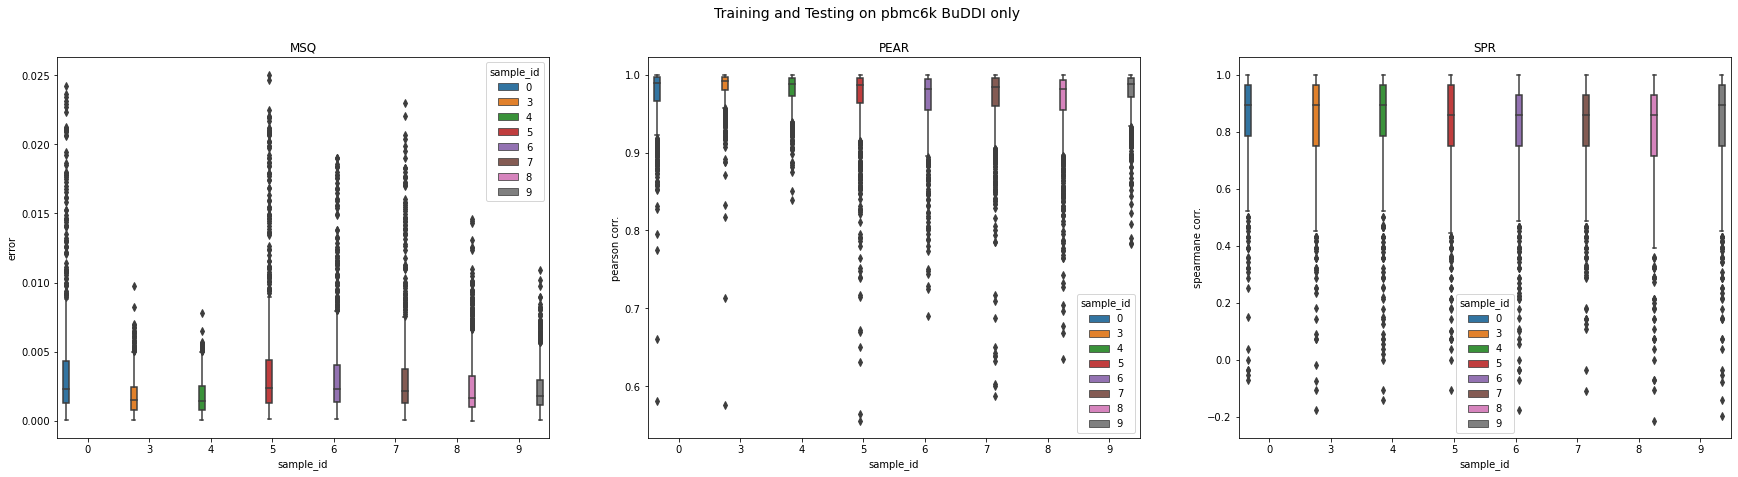

In [42]:
# Now compare across samples
idx_tmp = idx_unlab
num_unlab = np.unique(Label_full[idx_tmp])
idx_tmp = idx_unlab
X_tmp = X_full[idx_tmp,]
Y_tmp = Y_full.iloc[idx_tmp]

# make predictions
prop_outputs = pbmc6k_classifier.predict(X_tmp, batch_size=batch_size)

# calculate the error
buddi_err = get_errors(Y_tmp.to_numpy(), prop_outputs)

# format the errors
buddi_err["experiment"] = ["true_val"]*buddi_err.shape[0]
buddi_err["sample_id"] = np.tile(np.repeat(num_unlab, 1000), 3)
plot_df = buddi_err

# plot
fig, axs = plt.subplots(1, 3, figsize=(30,7))
sns.boxplot(data=plot_df[plot_df["error_type"] == "MSQ"], 
            x="sample_id", y="error",
            hue="sample_id", ax= axs[0])
axs[0].set_title("MSQ")

sns.boxplot(data=plot_df[plot_df["error_type"] == "PEAR"], 
            x="sample_id", y="error",
            hue="sample_id", ax= axs[1])
axs[1].set_title("PEAR")
axs[1].set(ylabel="pearson corr.")


sns.boxplot(data=plot_df[plot_df["error_type"] == "SPR"], 
            x="sample_id", y="error",
            hue="sample_id", ax= axs[2])
axs[2].set_title("SPR")
axs[2].set(ylabel="spearmane corr.")
fig.suptitle("Training and Testing on pbmc6k BuDDI only", fontsize=14)

fig.show()

# **Plot Recon + Embeddings**

### Methods

In [43]:
import umap

def get_umap_for_plotting(encodings):
    fit = umap.UMAP()
    umap_results = fit.fit_transform(encodings)

    plot_df = pd.DataFrame(umap_results[:,0:2])
    print(umap_results.shape)
    print(plot_df.shape)
    plot_df.columns = ['umap_0', 'umap_1']
    return plot_df

def plot_umap(plot_df, color_vec, ax, title, alpha=0.3):

    plot_df['Y'] = color_vec

    g = sns.scatterplot(
        x="umap_0", y="umap_1",
        data=plot_df.sample(frac=1),
        hue="Y",
        palette=sns.color_palette("hls", len(np.unique(color_vec))),
        legend="full",
        alpha=alpha, ax= ax
    )

    ax.set_title(title)
    return g


In [21]:
   
def get_tsne_for_plotting(encodings):
    tsne = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=500)
    tsne_results = tsne.fit_transform(encodings)

    plot_df = pd.DataFrame(tsne_results[:,0:2])
    print(tsne_results.shape)
    print(plot_df.shape)
    plot_df.columns = ['tsne_0', 'tsne_1']
    return plot_df

def plot_tsne(plot_df, color_vec, ax, title):

    plot_df['Y'] = color_vec

    g = sns.scatterplot(
        x="tsne_0", y="tsne_1",
        data=plot_df,
        hue="Y",
        palette=sns.color_palette("hls", len(np.unique(color_vec))),
        legend="full",
        alpha=0.3, ax= ax
    )

    ax.set_title(title)
    return g




In [22]:
from sklearn.decomposition import PCA

def get_pca_for_plotting(encodings):
    fit = PCA(n_components=2)
    pca_results = fit.fit_transform(encodings)

    plot_df = pd.DataFrame(pca_results[:,0:2])
    print(pca_results.shape)
    print(plot_df.shape)
    plot_df.columns = ['PCA_0', 'PCA_1']
    return plot_df

def plot_pca(plot_df, color_vec, ax, title):

    plot_df['Y'] = color_vec

    g = sns.scatterplot(
        x="PCA_0", y="PCA_1",
        data=plot_df,
        hue="Y",
        palette=sns.color_palette("hls", len(np.unique(color_vec))),
        legend="full",
        alpha=0.1, ax= ax
    )

    ax.set_title(title)
    return g

## Plot Reconstruction

In [23]:

X_temp = np.copy(X_full)


label_temp = np.copy(Label_full)
perturb_temp = Drug_full
source_temp = np.asarray([0]*10000)


# now use the encoder to get the latent spaces
z_slack, mu_slack, l_sigma_slack, z_rot, mu_rot, l_sigma_rot = pbmc6k_enc_unlab.predict(X_temp, batch_size=batch_size)

# now concatenate together
z_concat = np.hstack([z_slack, Y_full, z_rot])

# and decode
decoded_outputs = pbmc6k_dec.predict(z_concat, batch_size=batch_size)


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


(10000, 2)
(10000, 2)


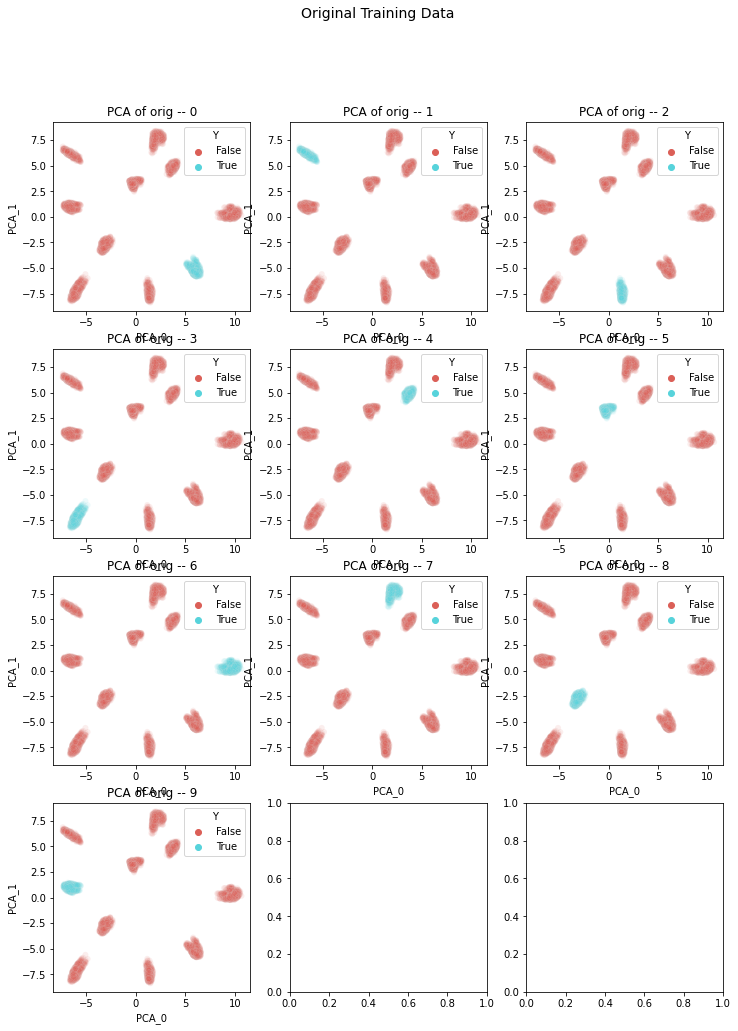

In [24]:

fig, axs = plt.subplots(4, 3, figsize=(12,16))

plot_df = get_pca_for_plotting(np.asarray(X_temp))
plot_pca(plot_df, color_vec=label_temp==0, ax=axs[0,0], title="PCA of orig -- 0")
plot_pca(plot_df, color_vec=label_temp==1, ax=axs[0,1], title="PCA of orig -- 1")
plot_pca(plot_df, color_vec=label_temp==2, ax=axs[0,2], title="PCA of orig -- 2")
plot_pca(plot_df, color_vec=label_temp==3, ax=axs[1,0], title="PCA of orig -- 3")
plot_pca(plot_df, color_vec=label_temp==4, ax=axs[1,1], title="PCA of orig -- 4")
plot_pca(plot_df, color_vec=label_temp==5, ax=axs[1,2], title="PCA of orig -- 5")
plot_pca(plot_df, color_vec=label_temp==6, ax=axs[2,0], title="PCA of orig -- 6")
plot_pca(plot_df, color_vec=label_temp==7, ax=axs[2,1], title="PCA of orig -- 7")
plot_pca(plot_df, color_vec=label_temp==8, ax=axs[2,2], title="PCA of orig -- 8")
plot_pca(plot_df, color_vec=label_temp==9, ax=axs[3,0], title="PCA of orig -- 9")


fig.suptitle("Original Training Data", fontsize=14)

fig.show()

(10000, 2)
(10000, 2)


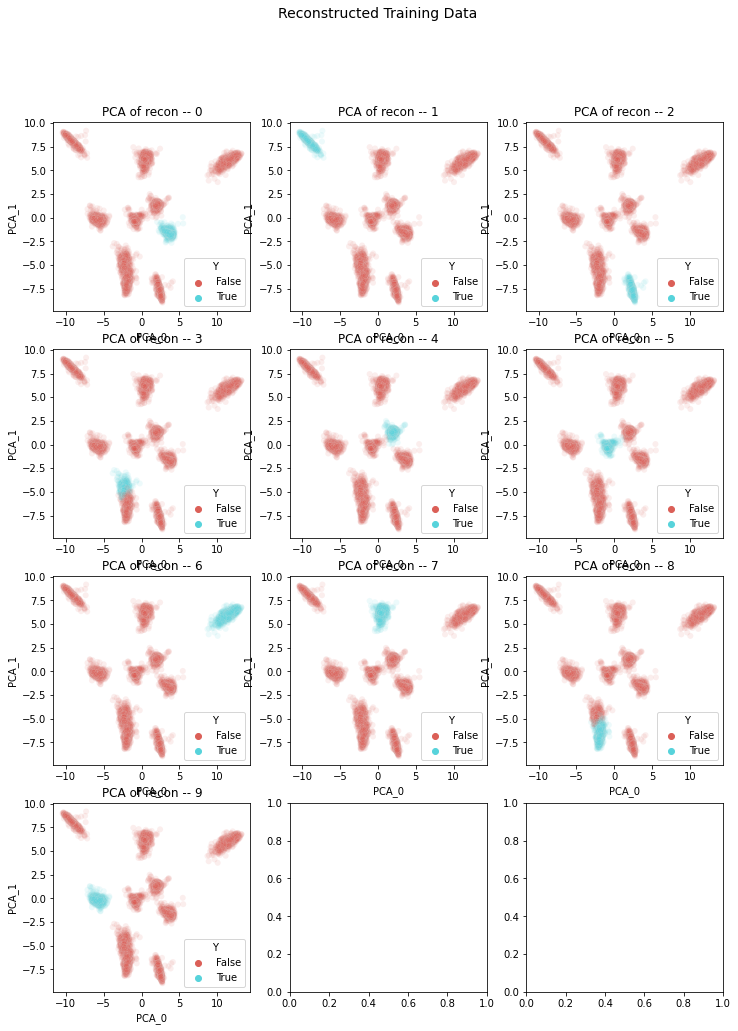

In [25]:

fig, axs = plt.subplots(4, 3, figsize=(12,16))

plot_df = get_pca_for_plotting(np.asarray(decoded_outputs))
plot_pca(plot_df, color_vec=label_temp==0, ax=axs[0,0], title="PCA of recon -- 0")
plot_pca(plot_df, color_vec=label_temp==1, ax=axs[0,1], title="PCA of recon -- 1")
plot_pca(plot_df, color_vec=label_temp==2, ax=axs[0,2], title="PCA of recon -- 2")
plot_pca(plot_df, color_vec=label_temp==3, ax=axs[1,0], title="PCA of recon -- 3")
plot_pca(plot_df, color_vec=label_temp==4, ax=axs[1,1], title="PCA of recon -- 4")
plot_pca(plot_df, color_vec=label_temp==5, ax=axs[1,2], title="PCA of recon -- 5")
plot_pca(plot_df, color_vec=label_temp==6, ax=axs[2,0], title="PCA of recon -- 6")
plot_pca(plot_df, color_vec=label_temp==7, ax=axs[2,1], title="PCA of recon -- 7")
plot_pca(plot_df, color_vec=label_temp==8, ax=axs[2,2], title="PCA of recon -- 8")
plot_pca(plot_df, color_vec=label_temp==9, ax=axs[3,0], title="PCA of recon -- 9")


fig.suptitle("Reconstructed Training Data", fontsize=14)

fig.show()

(20000, 2)
(20000, 2)


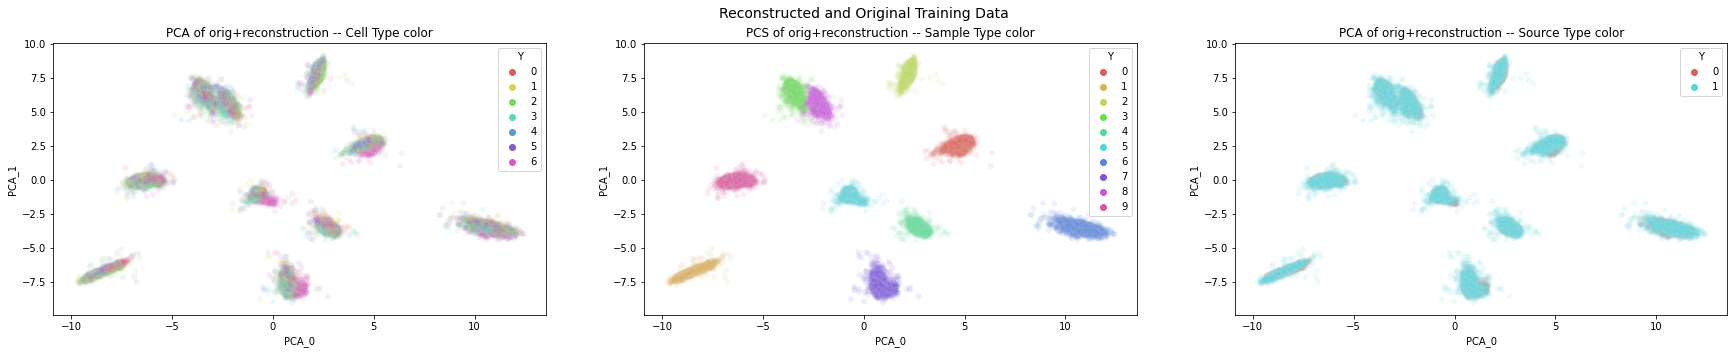

In [26]:
# make duplicated
X_dup = np.vstack([X_temp, decoded_outputs])


Y_temp = np.copy(Y_full)
Y_temp = np.argmax(Y_temp, axis=1)
Y_dup = np.append(Y_temp, Y_temp)

label_dup = np.append(label_temp, label_temp)
perturb_dup = np.append(perturb_temp, perturb_temp)
source_dup = np.asarray(np.append([0]*10000, [1]*10000))

fig, axs = plt.subplots(1, 3, figsize=(30,5))

plot_df = get_pca_for_plotting(np.asarray(X_dup))
plot_pca(plot_df, color_vec=Y_dup, ax=axs[0], title="PCA of orig+reconstruction -- Cell Type color")
plot_pca(plot_df, color_vec=label_dup, ax=axs[1], title="PCS of orig+reconstruction -- Sample Type color")
plot_pca(plot_df, color_vec=source_dup, ax=axs[2], title="PCA of orig+reconstruction -- Source Type color")


fig.suptitle("Reconstructed and Original Training Data", fontsize=14)

fig.show()

### Plot Latent Spaces

Number unique Y: 7
(10000, 2)
(10000, 2)
(10000, 2)
(10000, 2)
(10000, 2)
(10000, 2)
(10000, 2)
(10000, 2)


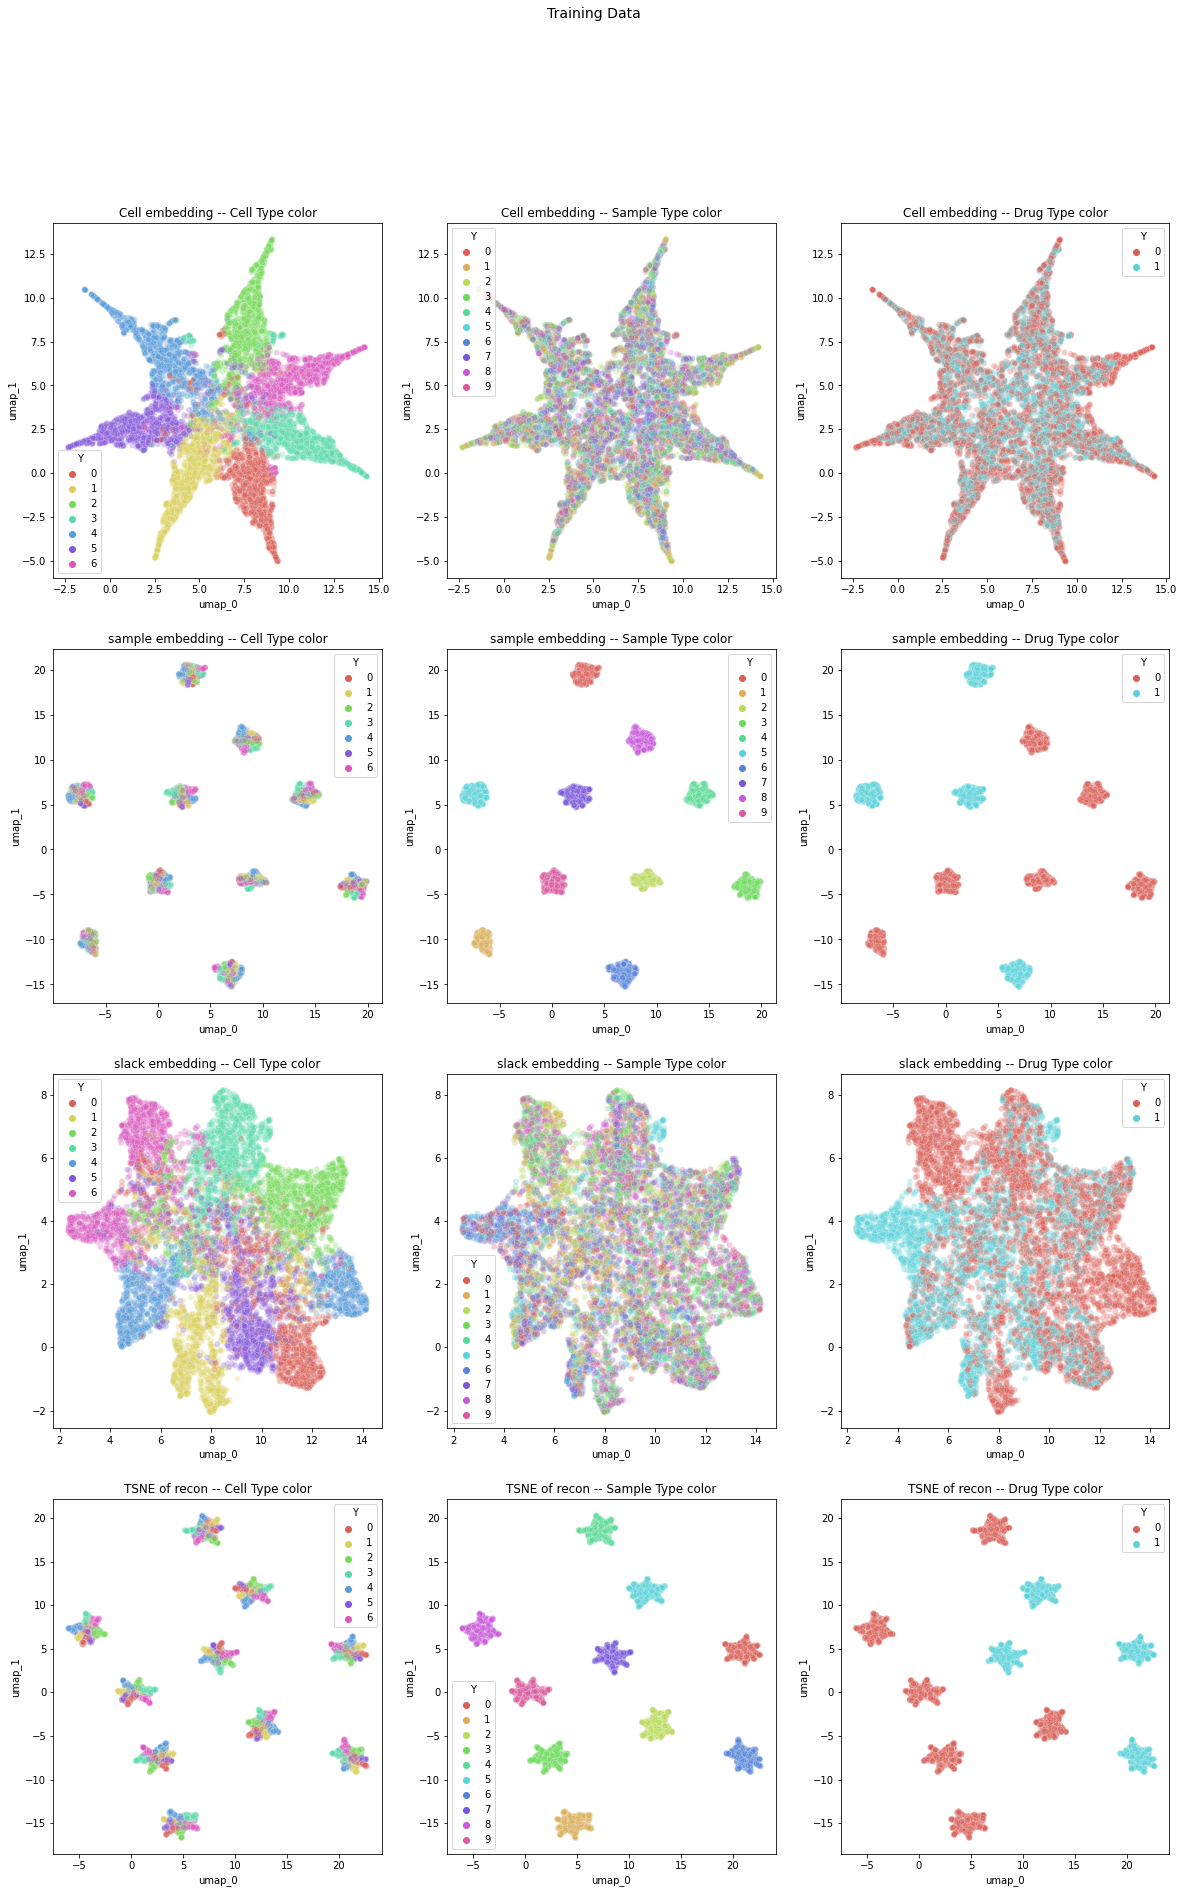

In [45]:
# plot proportions on labeled 10x and unlabeled 10x
# this is the training data

X_temp = np.copy(X_full)

Y_temp = np.copy(Y_full)
Y_temp = np.argmax(Y_temp, axis=1)

label_temp = np.copy(Label_full)
perturb_temp = Drug_full

print(f"Number unique Y: {len(np.unique(Y_temp))}")


z_slack, mu_slack, l_sigma_slack, z_rot, mu_rot, l_sigma_rot = pbmc6k_enc_unlab.predict(X_temp, batch_size=batch_size)
prop_outputs = pbmc6k_classifier.predict(X_temp, batch_size=batch_size)


# now concatenate together
z_concat = np.hstack([z_slack, Y_full, z_rot])

# and decode
decoded_outputs = pbmc6k_dec.predict(z_concat, batch_size=batch_size)


fig, axs = plt.subplots(4, 3, figsize=(20,30))

plot_df = get_umap_for_plotting(np.asarray(prop_outputs))
plot_umap(plot_df, color_vec=Y_temp, ax=axs[0,0], title="Cell embedding -- Cell Type color")
plot_umap(plot_df, color_vec=label_temp, ax=axs[0,1], title="Cell embedding -- Sample Type color")
plot_umap(plot_df, color_vec=perturb_temp, ax=axs[0,2], title="Cell embedding -- Drug Type color")

plot_df = get_umap_for_plotting(np.asarray(mu_rot))
plot_umap(plot_df, color_vec=Y_temp, ax=axs[1,0], title="sample embedding -- Cell Type color")
plot_umap(plot_df, color_vec=label_temp, ax=axs[1,1], title="sample embedding -- Sample Type color")
plot_umap(plot_df, color_vec=perturb_temp, ax=axs[1,2], title="sample embedding -- Drug Type color")

plot_df = get_umap_for_plotting(np.asarray(mu_slack))
plot_umap(plot_df, color_vec=Y_temp, ax=axs[2,0], title="slack embedding -- Cell Type color")
plot_umap(plot_df, color_vec=label_temp, ax=axs[2,1], title="slack embedding -- Sample Type color")
plot_umap(plot_df, color_vec=perturb_temp, ax=axs[2,2], title="slack embedding -- Drug Type color")

plot_df = get_umap_for_plotting(np.asarray(decoded_outputs))
plot_umap(plot_df, color_vec=Y_temp, ax=axs[3,0], title="TSNE of recon -- Cell Type color")
plot_umap(plot_df, color_vec=label_temp, ax=axs[3,1], title="TSNE of recon -- Sample Type color")
plot_umap(plot_df, color_vec=perturb_temp, ax=axs[3,2], title="TSNE of recon -- Drug Type color")




fig.suptitle("Training Data", fontsize=14)

fig.show()

Number unique Y: 7
(10000, 2)
(10000, 2)


/tmp/ipykernel_30273/1208196196.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['Y'] = color_vec
/tmp/ipykernel_30273/1208196196.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['Y'] = color_vec
/tmp/ipykernel_30273/1208196196.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

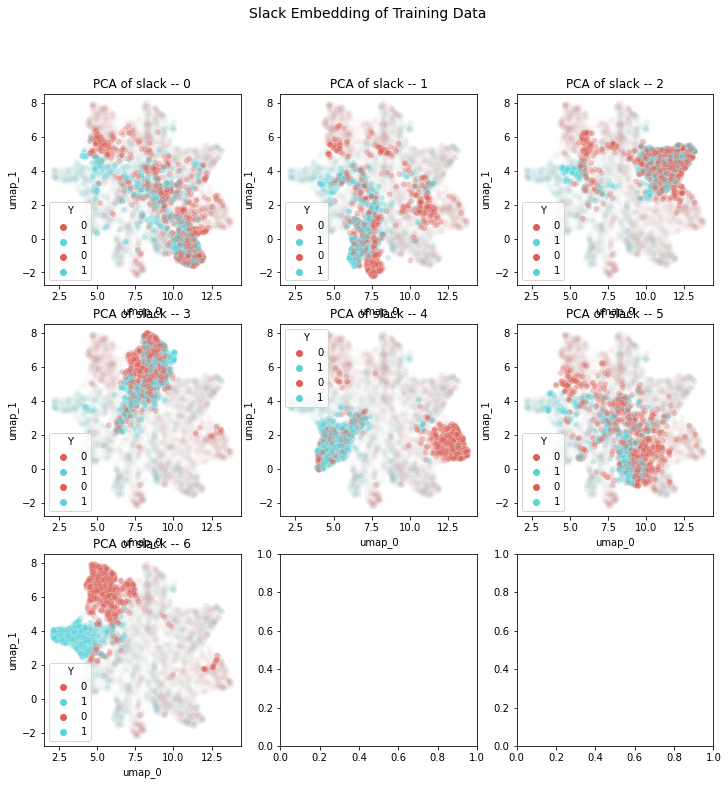

In [51]:

# plot proportions on labeled 10x and unlabeled 10x
# this is the training data

X_temp = np.copy(X_full)

Y_temp = np.copy(Y_full)
Y_temp = np.argmax(Y_temp, axis=1)

label_temp = np.copy(Label_full)
perturb_temp = Drug_full

print(f"Number unique Y: {len(np.unique(Y_temp))}")


z_slack, mu_slack, l_sigma_slack, z_rot, mu_rot, l_sigma_rot = pbmc6k_enc_unlab.predict(X_temp, batch_size=batch_size)

fig, axs = plt.subplots(3, 3, figsize=(12,12))

plot_df = get_umap_for_plotting(np.asarray(mu_slack))

plot_umap(plot_df, color_vec=perturb_temp, ax=axs[0,0], title="UMAP of recon -- 0", alpha=0.01)
plot_umap(plot_df.iloc[np.where(Y_temp == 0)], color_vec=perturb_temp[np.where(Y_temp == 0)], ax=axs[0,0], title="UMAP of slack -- 0")

plot_umap(plot_df, color_vec=perturb_temp, ax=axs[0,1], title="UMAP of recon -- 1", alpha=0.01)
plot_umap(plot_df.iloc[np.where(Y_temp == 1)], color_vec=perturb_temp[np.where(Y_temp == 1)], ax=axs[0,1], title="UMAP of slack -- 1")

plot_umap(plot_df, color_vec=perturb_temp, ax=axs[0,2], title="UMAP of recon -- 2", alpha=0.01)
plot_umap(plot_df.iloc[np.where(Y_temp == 2)], color_vec=perturb_temp[np.where(Y_temp == 2)], ax=axs[0,2], title="UMAP of slack -- 2")

plot_umap(plot_df, color_vec=perturb_temp, ax=axs[1,0], title="UMAP of recon -- 3", alpha=0.01)
plot_umap(plot_df.iloc[np.where(Y_temp == 3)], color_vec=perturb_temp[np.where(Y_temp == 3)], ax=axs[1,0], title="UMAP of slack -- 3")

plot_umap(plot_df, color_vec=perturb_temp, ax=axs[1,1], title="UMAP of recon -- 4", alpha=0.01)
plot_umap(plot_df.iloc[np.where(Y_temp == 4)], color_vec=perturb_temp[np.where(Y_temp == 4)], ax=axs[1,1], title="UMAP of slack -- 4")

plot_umap(plot_df, color_vec=perturb_temp, ax=axs[1,2], title="UMAP of recon -- 5", alpha=0.01)
plot_umap(plot_df.iloc[np.where(Y_temp == 5)], color_vec=perturb_temp[np.where(Y_temp == 5)], ax=axs[1,2], title="UMAP of slack -- 5")

plot_umap(plot_df, color_vec=perturb_temp, ax=axs[2,0], title="UMAP of recon -- 6", alpha=0.01)
plot_umap(plot_df.iloc[np.where(Y_temp == 6)], color_vec=perturb_temp[np.where(Y_temp == 6)], ax=axs[2,0], title="UMAP of slack -- 6")

fig.suptitle("Slack Embedding of Training Data, colored by cell id", fontsize=14)

fig.show()

Number unique Y: 7
(10000, 2)
(10000, 2)


/tmp/ipykernel_30273/1208196196.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['Y'] = color_vec
/tmp/ipykernel_30273/1208196196.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['Y'] = color_vec
/tmp/ipykernel_30273/1208196196.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

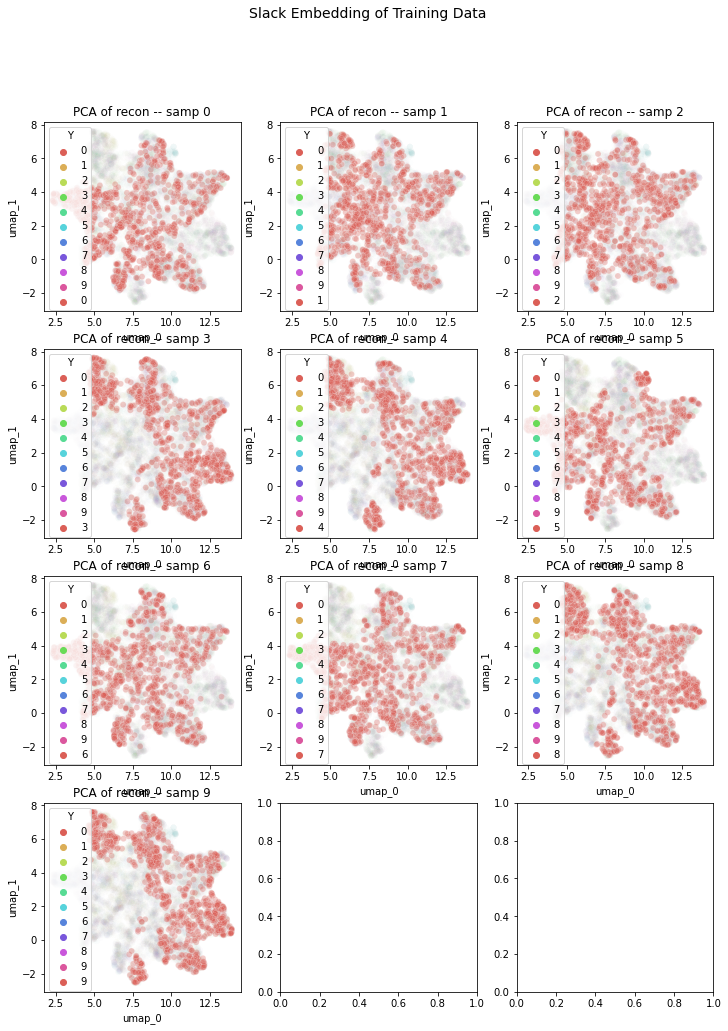

In [57]:

# plot proportions on labeled 10x and unlabeled 10x
# this is the training data

X_temp = np.copy(X_full)

Y_temp = np.copy(Y_full)
Y_temp = np.argmax(Y_temp, axis=1)

label_temp = np.copy(Label_full)
perturb_temp = Drug_full

print(f"Number unique Y: {len(np.unique(Y_temp))}")


z_slack, mu_slack, l_sigma_slack, z_rot, mu_rot, l_sigma_rot = pbmc6k_enc_unlab.predict(X_temp, batch_size=batch_size)

fig, axs = plt.subplots(4, 3, figsize=(12,16))

plot_df = get_umap_for_plotting(np.asarray(mu_slack))

plot_umap(plot_df, color_vec=label_temp, ax=axs[0,0], title="UMAP of recon -- samp 0", alpha=0.01)
plot_umap(plot_df.iloc[np.where(label_temp == 0)], color_vec=label_temp[np.where(label_temp == 0)], ax=axs[0,0], title="UMAP of recon -- samp 0")

plot_umap(plot_df, color_vec=label_temp, ax=axs[0,1], title="UMAP of recon -- samp 1", alpha=0.01)
plot_umap(plot_df.iloc[np.where(label_temp == 1)], color_vec=label_temp[np.where(label_temp == 1)], ax=axs[0,1], title="UMAP of recon -- samp 1")

plot_umap(plot_df, color_vec=label_temp, ax=axs[0,2], title="UMAP of recon -- samp 2", alpha=0.01)
plot_umap(plot_df.iloc[np.where(label_temp == 2)], color_vec=label_temp[np.where(label_temp == 2)], ax=axs[0,2], title="UMAP of recon -- samp 2")

plot_umap(plot_df, color_vec=label_temp, ax=axs[1,0], title="UMAP of recon -- samp 3", alpha=0.01)
plot_umap(plot_df.iloc[np.where(label_temp == 3)], color_vec=label_temp[np.where(label_temp == 3)], ax=axs[1,0], title="UMAP of recon -- samp 3")

plot_umap(plot_df, color_vec=label_temp, ax=axs[1,1], title="UMAP of recon -- samp 4", alpha=0.01)
plot_umap(plot_df.iloc[np.where(label_temp == 4)], color_vec=label_temp[np.where(label_temp == 4)], ax=axs[1,1], title="UMAP of recon -- samp 4")

plot_umap(plot_df, color_vec=label_temp, ax=axs[1,2], title="UMAP of recon -- samp 5", alpha=0.01)
plot_umap(plot_df.iloc[np.where(label_temp == 5)], color_vec=label_temp[np.where(label_temp == 5)], ax=axs[1,2], title="UMAP of recon -- samp 5")

plot_umap(plot_df, color_vec=label_temp, ax=axs[2,0], title="UMAP of recon -- samp 6", alpha=0.01)
plot_umap(plot_df.iloc[np.where(label_temp == 6)], color_vec=label_temp[np.where(label_temp == 6)], ax=axs[2,0], title="UMAP of recon -- samp 6")

plot_umap(plot_df, color_vec=label_temp, ax=axs[2,1], title="UMAP of recon -- samp 7", alpha=0.01)
plot_umap(plot_df.iloc[np.where(label_temp == 7)], color_vec=label_temp[np.where(label_temp == 7)], ax=axs[2,1], title="UMAP of recon -- samp 7")

plot_umap(plot_df, color_vec=label_temp, ax=axs[2,2], title="UMAP of recon -- samp 8", alpha=0.01)
plot_umap(plot_df.iloc[np.where(label_temp == 8)], color_vec=label_temp[np.where(label_temp == 8)], ax=axs[2,2], title="UMAP of recon -- samp 8")

plot_umap(plot_df, color_vec=label_temp, ax=axs[3,0], title="UMAP of recon -- samp 9", alpha=0.01)
plot_umap(plot_df.iloc[np.where(label_temp == 9)], color_vec=label_temp[np.where(label_temp == 9)], ax=axs[3,0], title="UMAP of recon -- samp 9")

fig.suptitle("Slack Embedding of Training Data, colored by sample ID", fontsize=14)

fig.show()

# **Do Latent Space projections**

In [28]:
# this is to generate noisy vector where the second elements is the largest
def add_vec_noise():
    a = np.random.lognormal(mean=0, sigma=1, size=7) + np.array([0,100,0,0,0,0,0])
    return a/a.sum()


## Shift Cell Type

In [29]:
# now we will take one cell type and project it across different sample IDs.
# this will allow us to see how well the reconstruction does

X_temp = np.copy(X_full)

# now use the encoder to get the latent spaces
z_slack, mu_slack, l_sigma_slack, z_rot, mu_rot, l_sigma_rot = pbmc6k_enc_unlab.predict(X_temp, batch_size=batch_size)

# first take all the samples from patient 1 where cell_0 is the max
label_temp = np.copy(Label_full)
Y_temp = np.copy(Y_full)
Y_temp = np.argmax(Y_temp, axis=1)
idx_0_patient = np.where(np.logical_and(label_temp == 0, Y_temp == 0))[0]

# and replace it with cell_1 -- with noise!
Y_1 = np.copy(Y_full)
noisy_prop_vec = [add_vec_noise() for i in range(len(idx_0_patient))]
noisy_prop_vec = np.vstack(noisy_prop_vec)

Y_1[idx_0_patient,] = noisy_prop_vec

# now concatenate together
z_concat_unlab_perturb = np.hstack([z_slack, Y_1, z_rot])

# and decode
decoded_0_1 = pbmc6k_dec.predict(z_concat_unlab_perturb, batch_size=batch_size)

# compare with original
z_concat_unlab_UNperturb = np.hstack([z_slack, Y_full, z_rot])
decoded_0_0 = pbmc6k_dec.predict(z_concat_unlab_UNperturb, batch_size=batch_size)




(10000, 2)
(10000, 2)
(10000, 2)
(10000, 2)


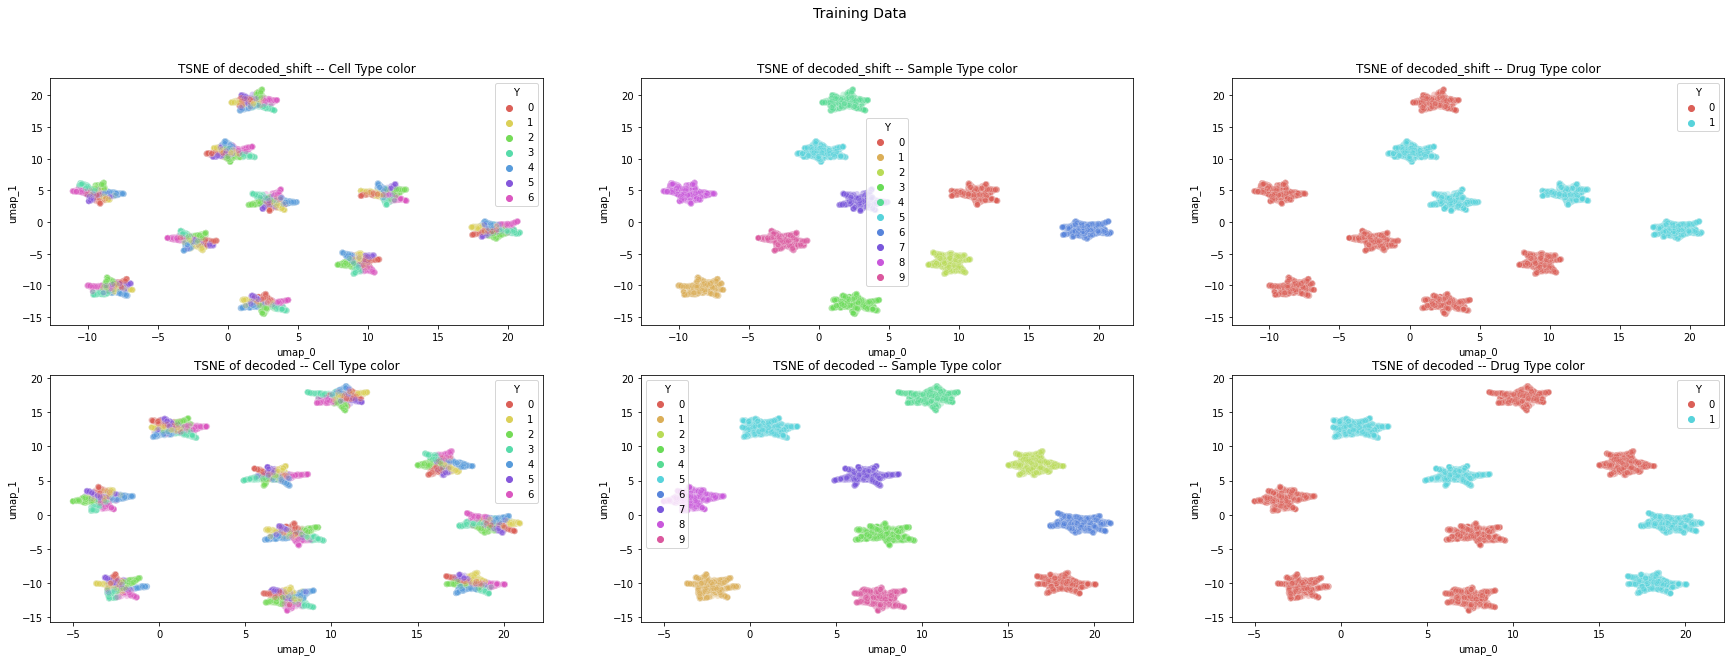

In [30]:
# Plot all Patients

label_temp = np.copy(Label_full)
perturb_temp = Drug_full
Y_temp = np.copy(Y_full)
Y_temp = np.argmax(Y_temp, axis=1)

fig, axs = plt.subplots(2, 3, figsize=(30,10))

plot_df = get_umap_for_plotting(np.asarray(decoded_0_1))
plot_umap(plot_df, color_vec=Y_temp, ax=axs[0,0], title="TSNE of decoded_shift -- Cell Type color")
plot_umap(plot_df, color_vec=label_temp, ax=axs[0,1], title="TSNE of decoded_shift -- Sample Type color")
plot_umap(plot_df, color_vec=perturb_temp, ax=axs[0,2], title="TSNE of decoded_shift -- Drug Type color")

plot_df = get_umap_for_plotting(np.asarray(decoded_0_0))
plot_umap(plot_df, color_vec=Y_temp, ax=axs[1,0], title="TSNE of decoded -- Cell Type color")
plot_umap(plot_df, color_vec=label_temp, ax=axs[1,1], title="TSNE of decoded -- Sample Type color")
plot_umap(plot_df, color_vec=perturb_temp, ax=axs[1,2], title="TSNE of decoded -- Drug Type color")


fig.suptitle("Training Data", fontsize=14)

fig.show()


(1000, 2)
(1000, 2)
(1000, 2)
(1000, 2)


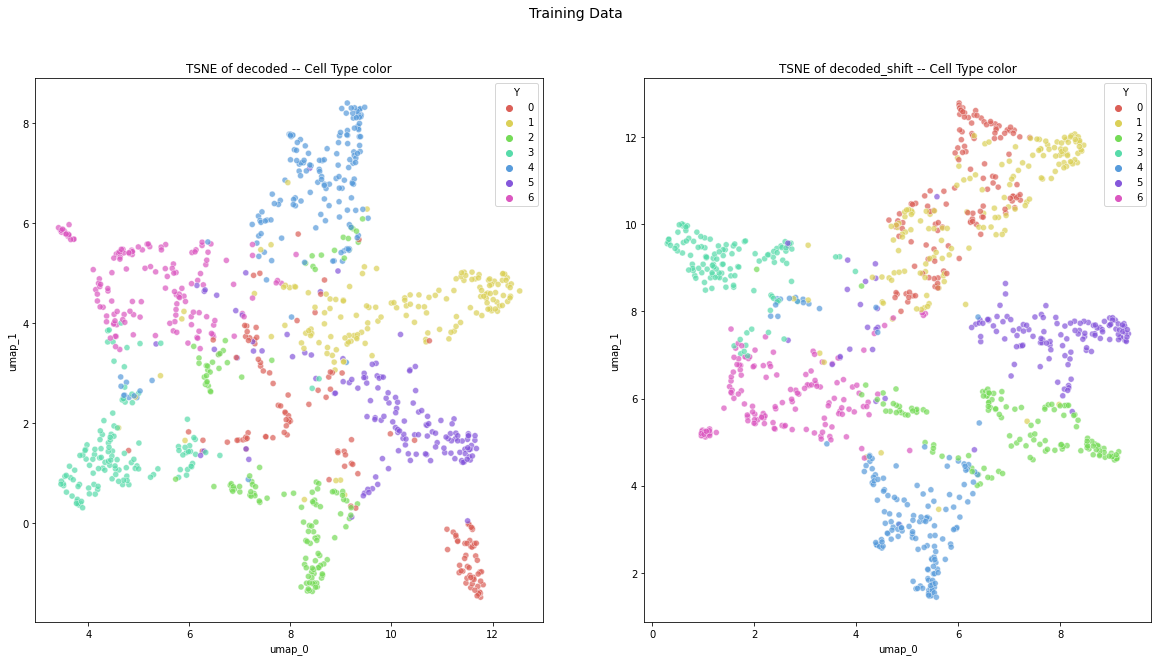

In [31]:
# Plot patient of interest

label_temp = np.copy(Label_full)
perturb_temp = Drug_full
Y_temp = np.copy(Y_full)
Y_temp = np.argmax(Y_temp, axis=1)

samp_0 = range(1000)

fig, axs = plt.subplots(1, 2, figsize=(20,10))


plot_df = get_umap_for_plotting(np.asarray(decoded_0_0[samp_0,]))
plot_umap(plot_df, color_vec=Y_temp[samp_0], ax=axs[0], title="TSNE of decoded -- Cell Type color", alpha=0.7)

plot_df = get_umap_for_plotting(np.asarray(decoded_0_1[samp_0,]))
plot_umap(plot_df, color_vec=Y_temp[samp_0], ax=axs[1], title="TSNE of decoded_shift -- Cell Type color", alpha=0.7)


fig.suptitle("Training Data", fontsize=14)

fig.show()




## Sample Projections

In [32]:
# now we will take one cell type and project it across different sample IDs.
# this will allow us to see how well the reconstruction does

X_temp = np.copy(X_full)

# now use the encoder to get the latent spaces
z_slack, mu_slack, l_sigma_slack, z_rot, mu_rot, l_sigma_rot = pbmc6k_enc_unlab.predict(X_temp, batch_size=batch_size)

# first take all the samples from patient 0 where cell_0 is the max
label_temp = np.copy(Label_full)
Y_temp = np.copy(Y_full)
Y_temp = np.argmax(Y_temp, axis=1)
idx_0_patient = np.where(np.logical_and(label_temp == 0, Y_temp == 0))[0]

# and take a random set of the samples from patient 1 
# of the length of idx_0_patient
# this is because we will use this random sample as our translation
idx_1_patient = np.where(label_temp == 1,)[0]
idx_1_patient = np.random.choice(idx_1_patient, len(idx_0_patient))

# now for patient 0, cell type 0
# we are shifting it to patient 1 cell type 0
# cell type should remain the same because the latent spaces are
# disentangled and we are not changing Y
z_rot_perturb = np.copy(z_rot)
z_rot_perturb[idx_0_patient,] = z_rot_perturb[idx_1_patient,]

# now concatenate together and decode
z_concat_unlab_perturb = np.hstack([z_slack, Y_full, z_rot_perturb])
decoded_0_1 = pbmc6k_dec.predict(z_concat_unlab_perturb, batch_size=batch_size)

# compare with original
z_concat_unlab_UNperturb = np.hstack([z_slack, Y_full, z_rot])
decoded_0_0 = pbmc6k_dec.predict(z_concat_unlab_UNperturb, batch_size=batch_size)




(10000, 2)
(10000, 2)


/tmp/ipykernel_30273/1232243567.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['Y'] = color_vec


(10000, 2)
(10000, 2)


/tmp/ipykernel_30273/1232243567.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['Y'] = color_vec


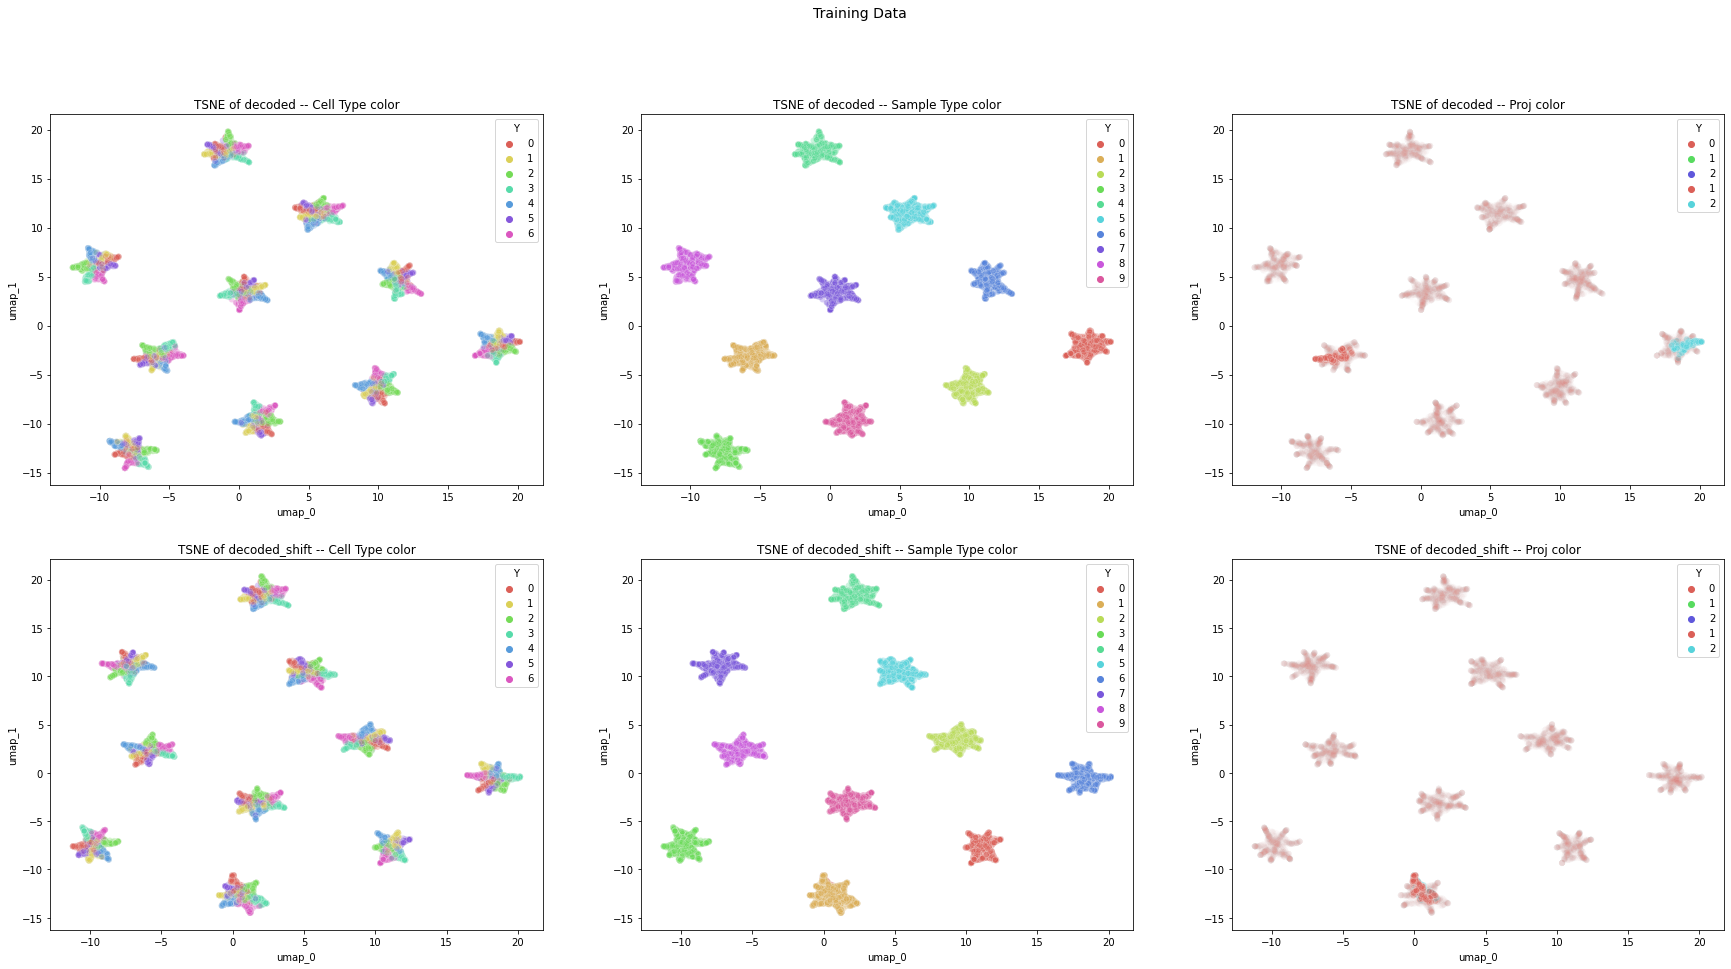

In [33]:
# Plot all patients

label_temp = np.copy(Label_full)
perturb_temp = Drug_full
Y_temp = np.copy(Y_full)
Y_temp = np.argmax(Y_temp, axis=1)

proj_temp = np.array([0]*len(Y_temp)) # ["other"]*len(Y_temp)

idx_proj_cell0 = np.where(np.logical_and(Y_temp == 0, label_temp == 1))[0]
idx_reg_cell0 = np.where(np.logical_and(Y_temp == 0, label_temp == 0))[0]

proj_temp[idx_proj_cell0] = 1 #"cell0 samp 0"
proj_temp[idx_reg_cell0] = 2 #"cell0 samp 1"


only_cell_0_interest = np.union1d(idx_proj_cell0, idx_reg_cell0)

fig, axs = plt.subplots(2, 3, figsize=(30,15))

plot_df = get_umap_for_plotting(np.asarray(decoded_0_0))
plot_umap(plot_df, color_vec=Y_temp, ax=axs[0,0], title="TSNE of decoded -- Cell Type color")
plot_umap(plot_df, color_vec=label_temp, ax=axs[0,1], title="TSNE of decoded -- Sample Type color")
plot_umap(plot_df, color_vec=proj_temp, ax=axs[0,2], title="TSNE of decoded -- Proj color", alpha=0.01)
plot_umap(plot_df.iloc[only_cell_0_interest], color_vec=proj_temp[only_cell_0_interest], ax=axs[0,2], title="TSNE of decoded -- Proj color")

plot_df = get_umap_for_plotting(np.asarray(decoded_0_1))
plot_umap(plot_df, color_vec=Y_temp, ax=axs[1,0], title="TSNE of decoded_shift -- Cell Type color")
plot_umap(plot_df, color_vec=label_temp, ax=axs[1,1], title="TSNE of decoded_shift -- Sample Type color")
plot_umap(plot_df, color_vec=proj_temp, ax=axs[1,2], title="TSNE of decoded_shift -- Proj color", alpha=0.01)
plot_umap(plot_df.iloc[only_cell_0_interest], color_vec=proj_temp[only_cell_0_interest], ax=axs[1,2], title="TSNE of decoded_shift -- Proj color")


fig.suptitle("Training Data", fontsize=14)

fig.show()



(2000, 2)
(2000, 2)
(2000, 2)
(2000, 2)


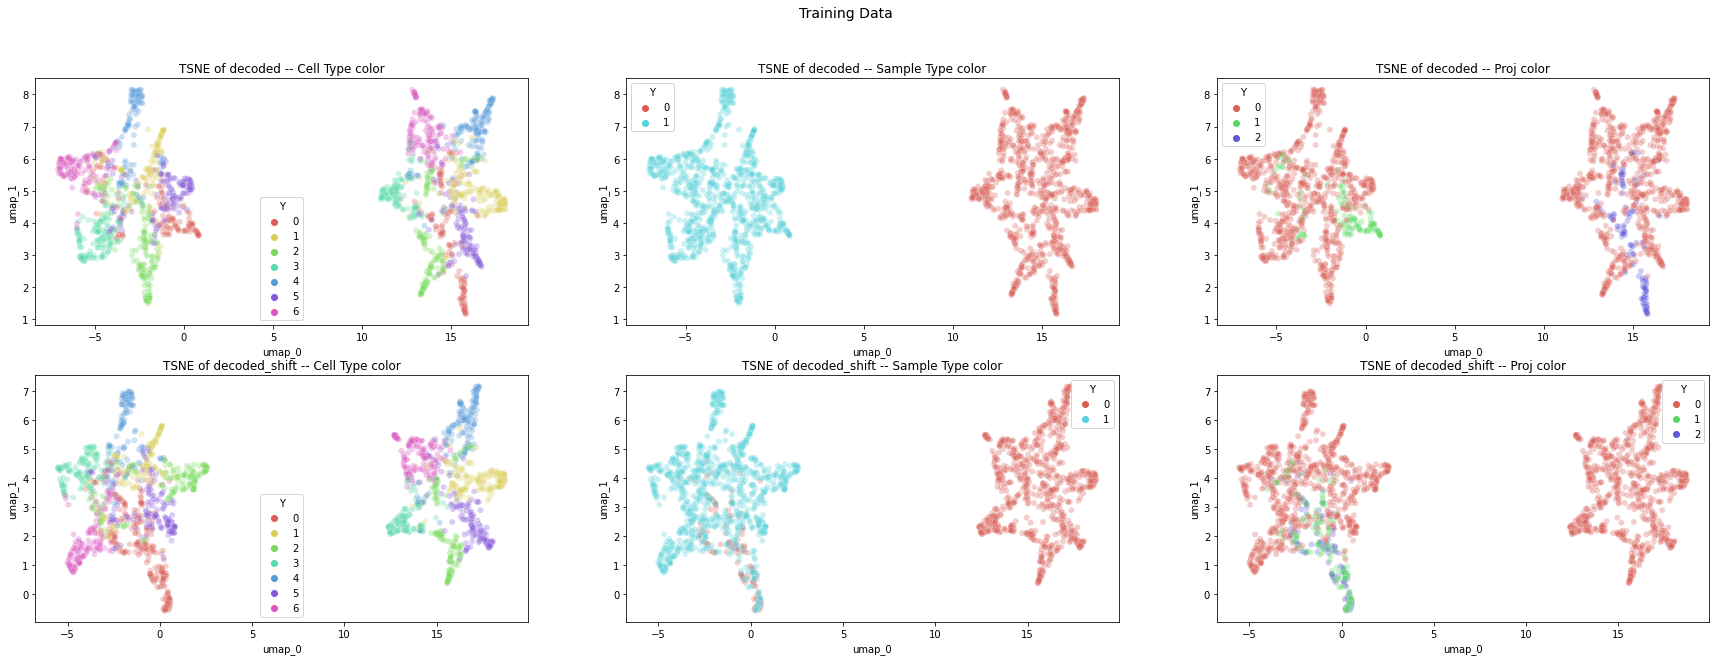

In [34]:
# Plot patient of interest

label_temp = np.copy(Label_full)
perturb_temp = Drug_full
Y_temp = np.copy(Y_full)
Y_temp = np.argmax(Y_temp, axis=1)

proj_temp = np.array([0]*len(Y_temp)) # ["other"]*len(Y_temp)

idx_proj_cell0 = np.where(np.logical_and(Y_temp == 0, label_temp == 1))[0]
idx_reg_cell0 = np.where(np.logical_and(Y_temp == 0, label_temp == 0))[0]

proj_temp[idx_proj_cell0] = 1 #"cell0 projected to samp 1"
proj_temp[idx_reg_cell0] = 2 #"cell0 already in samp 1"


samp_0 = range(2000)

fig, axs = plt.subplots(2, 3, figsize=(30,10))


plot_df = get_umap_for_plotting(np.asarray(decoded_0_0[samp_0,]))
plot_umap(plot_df, color_vec=Y_temp[samp_0], ax=axs[0,0], title="TSNE of decoded -- Cell Type color")
plot_umap(plot_df, color_vec=label_temp[samp_0], ax=axs[0,1], title="TSNE of decoded -- Sample Type color")
plot_umap(plot_df, color_vec=proj_temp[samp_0], ax=axs[0,2], title="TSNE of decoded -- Proj color")

plot_df = get_umap_for_plotting(np.asarray(decoded_0_1[samp_0,]))
plot_umap(plot_df, color_vec=Y_temp[samp_0], ax=axs[1,0], title="TSNE of decoded_shift -- Cell Type color")
plot_umap(plot_df, color_vec=label_temp[samp_0], ax=axs[1,1], title="TSNE of decoded_shift -- Sample Type color")
plot_umap(plot_df, color_vec=proj_temp[samp_0], ax=axs[1,2], title="TSNE of decoded_shift -- Proj color")


fig.suptitle("Training Data", fontsize=14)

fig.show()

